In this notebook, we will finally create predictive features using the logs we cleaned on notebook 2.2. Our focus, for now, will be prediction using an aggregate non-temporal representation of each student.

Throughout the notebook, we will start with the import of logs and remaining tables that we consider to be relevant for feature engineering and extraction.

#### 1. Importing the relevant packages, setting global variables and importing the relevant files

In [1]:
#import libs
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *

#viz related tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta
from copy import copy, deepcopy

#starting with other tools
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#to save
import xlsxwriter

In [2]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

#Function designed to deal with multiindex and flatten it
def flattenHierarchicalCol(col,sep = '_'):
    '''converts multiindex columns into single index columns while retaining the hierarchical components'''
    if not type(col) is tuple:
        return col
    else:
        new_col = ''
        for leveli,level in enumerate(col):
            if not level == '':
                if not leveli == 0:
                    new_col += sep
                new_col += level
        return new_col

In [3]:
#loading student log data 
student_logs = pd.read_csv('../Data/Modeling Stage/R_Gonz_cleaned_logs.csv', 
                           dtype = {
                                   'id': object,
                                   'itemid': object,
                                   'userid': object,
                                   'course': object,
                                   'cmid': object,
                                   },
                                   parse_dates = ['time'],).drop(['Unnamed: 0', 'id', 'url', 'info'], axis = 1).dropna(how = 'all', axis = 1) #logs

#loading support table
support_table = pd.read_csv('../Data/R_Gonz_support_table.csv', 
                           dtype = {
                                   'assign_id': object,
                                   'courseid': object,
                                   'userid': object,
                                   }, 
                            parse_dates = ['sup_time', 'startdate']).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1)

#save tables 
class_list = pd.read_csv('../Data/Modeling Stage/R_Gonz_class_duration.csv', 
                         dtype = {
                                   'course': object,                                   
                                   },
                        parse_dates = ['Start Date','End Date', 'cuttoff_point']).drop('Unnamed: 0', axis = 1).rename(columns = {'cuttoff_point' : 'Week before start'})

#targets tables 
targets_table = pd.read_csv('../Data/Modeling Stage/R_Gonz_targets_table.csv',
                           dtype = {
                                   'userid': object,
                                   'courseid': object,
                                   },)

We'll start with the general verification of the different datasets we've imported. 

**Starting with the targets table, which includes all valid student-course logs with Final-Grade.**

In [4]:
#get info
targets_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30510 entries, 0 to 30509
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   courseid         30510 non-null  object 
 1   userid           30510 non-null  object 
 2   Grade Mandatory  26676 non-null  float64
 3   Grade Optional   16485 non-null  float64
 4   final_mark       30510 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.2+ MB


In [5]:
targets_table.describe(include = 'all', datetime_is_numeric = True)

,courseid,userid,Grade Mandatory,Grade Optional,final_mark
count,30510,30510,26676.000000,16485.000000,30510.000000
unique,732,14111,NaN,NaN,NaN
top,2271.0,36779.0,NaN,NaN,NaN
freq,667,10,NaN,NaN,NaN
mean,NaN,NaN,0.303199,0.086236,4.715297
std,NaN,NaN,0.151369,0.144909,3.121882
min,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,0.210688,0.000000,2.194832
50%,NaN,NaN,0.339517,0.000000,4.666666
75%,NaN,NaN,0.424005,0.125375,7.423107


In [6]:
targets_table.rename(columns = {'courseid' : 'course'}, inplace = True)

Then, we repeat the same for the list of courses and their respective start and end dates. We know that the number of students attending each course is the number found in the logs. We will need to make further cuts 

In [7]:
class_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   course                573 non-null    object        
 1   Users per course      573 non-null    float64       
 2   Start Date            573 non-null    datetime64[ns]
 3   End Date              573 non-null    datetime64[ns]
 4   Course duration days  573 non-null    float64       
 5   Week before start     573 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(2), object(1)
memory usage: 27.0+ KB


In [8]:
class_list.describe(include = 'all', datetime_is_numeric = True)

,course,Users per course,Start Date,End Date,Course duration days,Week before start
count,573,573.000000,573,573,573.000000,573
unique,573,NaN,NaN,NaN,NaN,NaN
top,1000.0,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,50.436300,2014-11-17 01:45:32.984293376,2015-03-21 03:51:12.251308800,125.087260,2014-11-10 01:45:32.984293120
min,NaN,1.000000,2014-08-25 00:00:00,2014-10-03 00:00:00,33.000000,2014-08-18 00:00:00
25%,NaN,16.000000,2014-09-08 00:00:00,2015-01-16 00:00:00,103.000000,2014-09-01 00:00:00
50%,NaN,33.000000,2014-10-20 00:00:00,2015-03-06 00:00:00,124.000000,2014-10-13 00:00:00
75%,NaN,69.000000,2015-01-19 00:00:00,2015-05-29 00:00:00,138.000000,2015-01-12 00:00:00
max,NaN,642.000000,2015-06-29 00:00:00,2015-07-31 00:00:00,306.000000,2015-06-22 00:00:00


In [9]:
class_list

,course,Users per course,Start Date,End Date,Course duration days,Week before start
0,1000.0,12.0,2014-08-25,2015-01-23,152.0,2014-08-18
1,1002.0,22.0,2014-09-22,2015-03-06,166.0,2014-09-15
2,1010.0,48.0,2014-09-08,2014-12-26,110.0,2014-09-01
3,1013.0,71.0,2014-09-22,2015-02-06,138.0,2014-09-15
4,1020.0,64.0,2015-01-05,2015-06-05,152.0,2014-12-29
...,...,...,...,...,...,...
568,961.0,12.0,2015-02-02,2015-05-22,110.0,2015-01-26
569,984.0,13.0,2014-08-25,2015-01-30,159.0,2014-08-18
570,992.0,16.0,2015-02-09,2015-05-15,96.0,2015-02-02
571,993.0,55.0,2014-09-08,2015-01-16,131.0,2014-09-01


We still note a significant presence of courses with small numbers of students. The first step we will take is the removal of all courses whose number of attending students is below 50.

In [10]:
class_list = class_list[class_list['Users per course'] >= 50]

#updating student logs
student_logs = student_logs[student_logs['course'].isin(class_list['course'])]


#additionally updating targets_table
targets_table = targets_table[targets_table['course'].isin(class_list['course'])]
class_list.describe(include = 'all', datetime_is_numeric = True)

,course,Users per course,Start Date,End Date,Course duration days,Week before start
count,226,226.000000,226,226,226.000000,226
unique,226,NaN,NaN,NaN,NaN,NaN
top,1013.0,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,95.951327,2014-11-12 13:41:56.814159360,2015-03-24 03:36:38.230088448,132.579646,2014-11-05 13:41:56.814159360
min,NaN,50.000000,2014-08-25 00:00:00,2014-10-10 00:00:00,33.000000,2014-08-18 00:00:00
25%,NaN,62.000000,2014-09-08 00:00:00,2015-01-23 00:00:00,110.000000,2014-09-01 00:00:00
50%,NaN,77.000000,2014-10-20 00:00:00,2015-03-06 00:00:00,131.000000,2014-10-13 00:00:00
75%,NaN,106.500000,2015-01-19 00:00:00,2015-05-29 00:00:00,145.000000,2015-01-12 00:00:00
max,NaN,642.000000,2015-05-18 00:00:00,2015-07-03 00:00:00,299.000000,2015-05-11 00:00:00


We'll follow up with taking a closer look logs we cleaned in the previous section. 

In [11]:
student_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5192790 entries, 5132 to 6911838
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   userid  object        
 2   ip      object        
 3   course  object        
 4   module  object        
 5   cmid    object        
 6   action  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 316.9+ MB


In [12]:
student_logs.describe(include = 'all', datetime_is_numeric = True)

,time,userid,ip,course,module,cmid,action
count,5192790,5192790,5192790,5192790,5192790,5192790,5192790
unique,NaN,10703,59091,226,29,14148,94
top,NaN,47527.0,127.0.0.1,2059.0,course,0.0,view
freq,NaN,40537,3117945,131233,2122418,2374132,4107551
mean,2015-01-16 17:59:16.473498624,NaN,NaN,NaN,NaN,NaN,NaN
min,2014-09-01 18:53:34,NaN,NaN,NaN,NaN,NaN,NaN
25%,2014-11-10 10:45:53.500000,NaN,NaN,NaN,NaN,NaN,NaN
50%,2015-01-12 09:58:09.500000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2015-03-23 14:23:11.500000,NaN,NaN,NaN,NaN,NaN,NaN
max,2015-06-29 23:24:54,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
student_logs

,time,userid,ip,course,module,cmid,action
5132,2014-09-01 18:53:34,47196.0,127.0.0.1,2055.0,course,0.0,view
5133,2014-09-01 18:53:39,47196.0,127.0.0.1,2055.0,resource,85645.0,view
5134,2014-09-01 18:53:56,47196.0,127.0.0.1,2055.0,course,0.0,view
5135,2014-09-01 18:54:01,47196.0,127.0.0.1,2055.0,course,0.0,view
5136,2014-09-01 18:54:06,47196.0,127.0.0.1,2055.0,user,0.0,view all
...,...,...,...,...,...,...,...
6911104,2015-06-15 15:37:19,54662.0,127.0.0.1,3094.0,course,0.0,view
6911105,2015-06-15 15:37:38,54662.0,127.0.0.1,3094.0,course,0.0,view
6911836,2015-06-18 08:57:58,52262.0,127.0.0.1,2411.0,course,0.0,view
6911837,2015-06-18 08:58:35,52262.0,127.0.0.1,2411.0,resource,105562.0,view


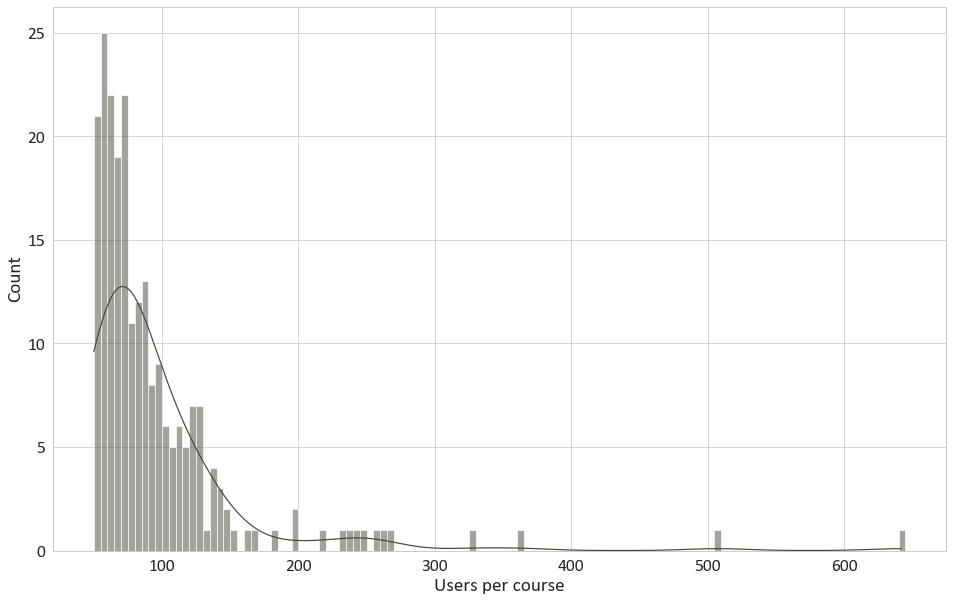

In [14]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)
hist4 = sns.histplot(data=class_list, x='Users per course', kde=True, color= student_color, binwidth = 5,)

fig = hist4.get_figure()
fig.savefig('../Images/hist4_students_per_course_bin_5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist4


Likewise, there is some attention to be found on courses with abnormally high numbers of attending students in a face-to-face context (over 200). We will pay closer attention to those courses.

In [15]:
#create df only with high affluence courses
most_affluent_courses = class_list[class_list['Users per course'] >= 200]

#separate logs accordingly
high_attendance_logs = student_logs[student_logs['course'].isin(most_affluent_courses['course'])]
high_attendance_logs

,time,userid,ip,course,module,cmid,action
37544,2014-09-03 10:32:56,69599.0,127.0.0.1,2007.0,course,0.0,view
37545,2014-09-03 10:33:10,69599.0,127.0.0.1,2007.0,user,0.0,view all
37546,2014-09-03 10:39:27,69599.0,127.0.0.1,2007.0,course,0.0,view
37547,2014-09-03 10:42:23,69599.0,127.0.0.1,2007.0,course,0.0,view
37548,2014-09-03 10:42:28,69599.0,127.0.0.1,2007.0,resource,83279.0,view
...,...,...,...,...,...,...,...
6893726,2015-06-23 13:44:08,47237.0,127.0.0.1,3022.0,course,0.0,view
6893727,2015-06-28 13:59:04,47237.0,127.0.0.1,3022.0,course,0.0,view
6911836,2015-06-18 08:57:58,52262.0,127.0.0.1,2411.0,course,0.0,view
6911837,2015-06-18 08:58:35,52262.0,127.0.0.1,2411.0,resource,105562.0,view


In [16]:
high_attendance_logs.describe(include = 'all', datetime_is_numeric = 'all')

,time,userid,ip,course,module,cmid,action
count,814345,814345,814345,814345,814345,814345,814345
unique,NaN,2680,8729,12,15,1006,34
top,NaN,63280.0,127.0.0.1,2059.0,course,0.0,view
freq,NaN,2982,610465,131233,357294,375698,675719
mean,2015-02-16 11:50:14.820510464,NaN,NaN,NaN,NaN,NaN,NaN
min,2014-09-03 10:32:56,NaN,NaN,NaN,NaN,NaN,NaN
25%,2014-12-11 13:50:17,NaN,NaN,NaN,NaN,NaN,NaN
50%,2015-03-04 15:25:20,NaN,NaN,NaN,NaN,NaN,NaN
75%,2015-04-20 09:07:41,NaN,NaN,NaN,NaN,NaN,NaN
max,2015-06-28 23:23:50,NaN,NaN,NaN,NaN,NaN,NaN


We can plot the weekly interactions of these courses.

In [17]:
#Then, when it comes to logs, we aggregate by week
grouped_data = high_attendance_logs.groupby([pd.Grouper(key='time', freq='W'), 'course']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['course'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index('Course', drop = True)
grouped_data.T.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Course,,,,,,,,
2007,18.0,2106.055556,1100.755007,116.0,1594.25,1977.5,2705.25,4439.0
2024,21.0,3182.571429,1973.936361,233.0,1540.00,2949.0,4940.00,6549.0
2059,19.0,6907.000000,4345.670924,1597.0,3700.50,5636.0,10547.50,16615.0
2271,18.0,6002.722222,3828.539728,942.0,3792.50,4467.5,9135.25,14147.0
2288,19.0,4139.421053,2721.201334,1533.0,2243.50,3173.0,4674.00,10809.0
2411,23.0,2794.434783,1978.090122,123.0,1494.00,2555.0,3421.50,7784.0
2607,23.0,4520.739130,4155.541122,10.0,2174.50,3697.0,5221.50,20018.0
3022,30.0,1465.800000,1372.654700,94.0,247.25,1331.0,1893.00,5552.0
3033,19.0,2110.631579,1560.074400,524.0,820.00,1478.0,2935.50,5435.0


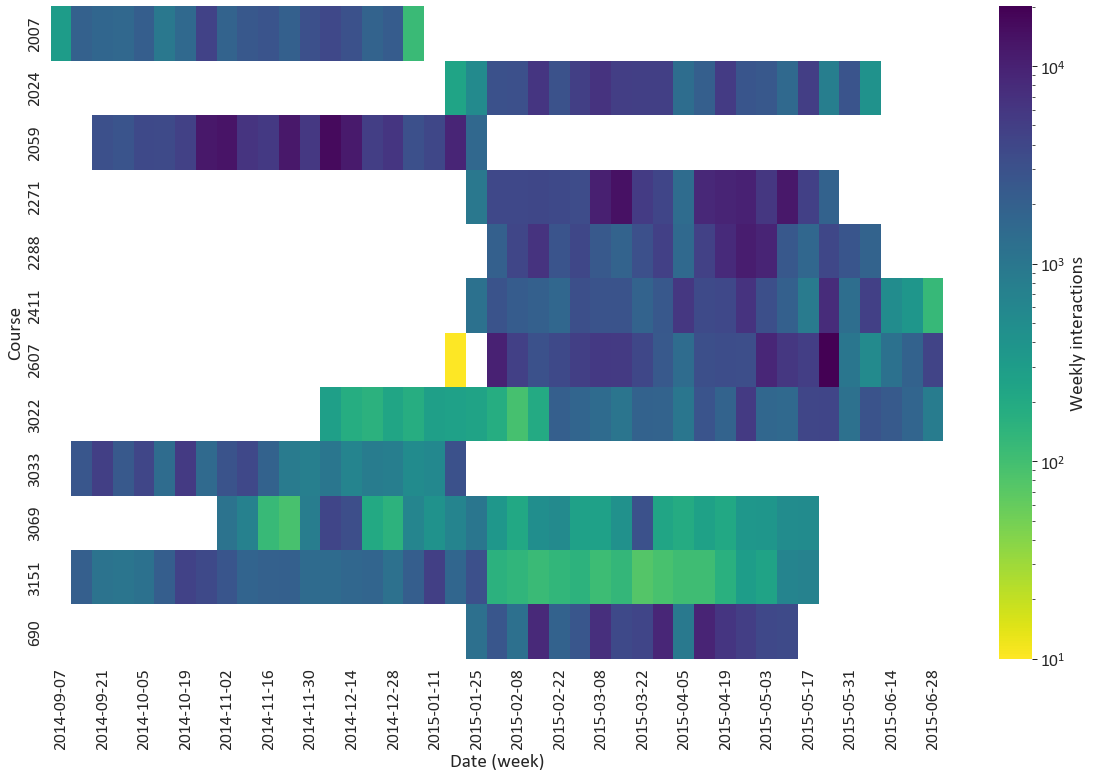

In [18]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the nex
heat4 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= 1,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat4.get_figure()
fig.savefig('../Images/highest_attendance_weekly_clicks_heat4.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat4

While most courses are very clearly restricted to their semester, there are courses that have interactions occurring across the entire year. 

For these courses, we just want to undestand whether all students are interacting continuously or we are speaking of different co-horts of students. As such, we will look more deeply at the following courses:

3022, 3069 and 3151

In [19]:
year_long_high_attendance = ['3022.0', '3069.0', '3151.0']

#Then, when it comes to logs, we aggregate by week
grouped_data = high_attendance_logs[high_attendance_logs['course'].isin(year_long_high_attendance)].groupby([pd.Grouper(key='time', freq='W'), 'course', 'userid']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['course', 'userid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Course', 'userid'], drop = True)
grouped_data.T.describe(include = 'all').T

count       mean        std  min   25%   50%    75%    max
Course userid                                                             
3022   14727.0   23.0  20.173913  30.986290  1.0  2.50  11.0  19.50  142.0
       19329.0   15.0  21.733333  24.618421  1.0  4.00   8.0  42.00   67.0
       23000.0   19.0  12.526316  10.073995  1.0  3.50  10.0  21.50   33.0
       23427.0   13.0  17.230769  19.110005  2.0  5.00  12.0  17.00   67.0
       26356.0   16.0  14.937500  14.359521  1.0  3.00  11.0  19.75   54.0
...               ...        ...        ...  ...   ...   ...    ...    ...
3151   66551.0   22.0  17.454545  18.712683  1.0  5.00  11.0  26.00   77.0
       71150.0   25.0  27.160000  28.125730  1.0  3.00  21.0  33.00  104.0
       72025.0    8.0   8.625000   4.565007  2.0  5.75   9.0   9.75   17.0
       72952.0    8.0   7.750000   4.621379  1.0  4.75   7.5  10.00   15.0
       74192.0   13.0  17.769231  16.161445  1.0  5.00  13.0  25.00   52.0

[719 rows x 8 columns]

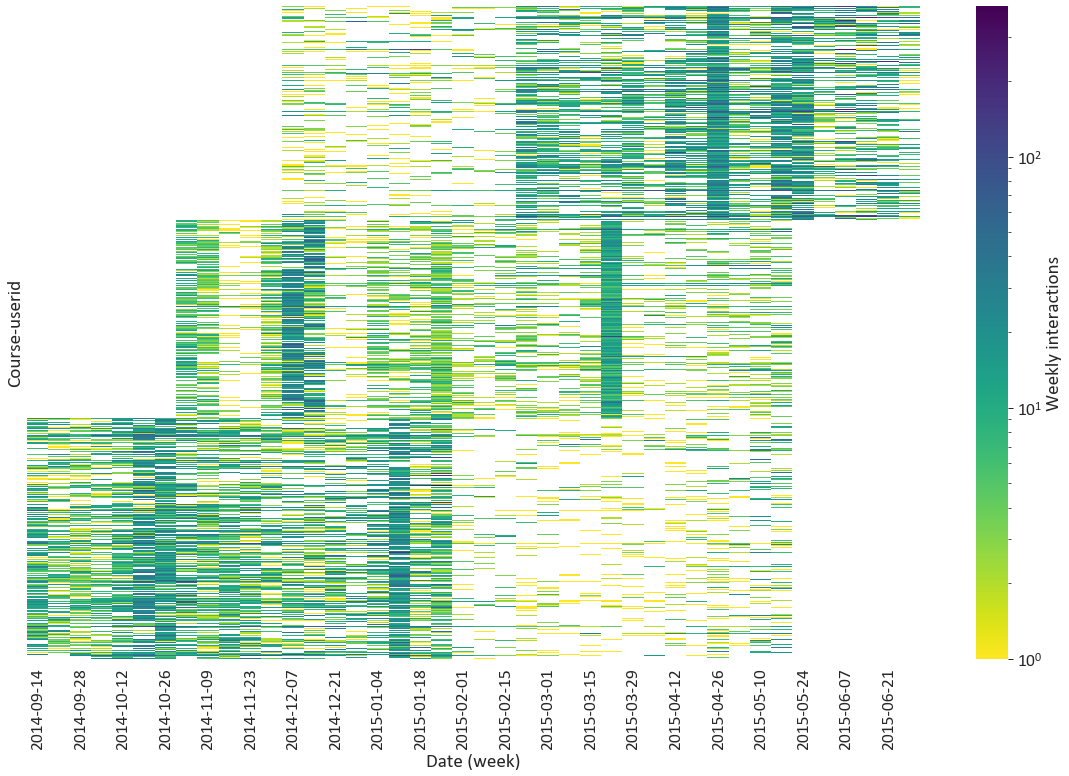

In [20]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the nex
heat5 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= 0,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat5.get_figure()
fig.savefig('../Images/high_attend_yearlong_weekly_heat5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat5, grouped_data, high_attendance_logs, year_long_high_attendance

After consideration, we find that the student interactions seem to be consistent with the course duration. 

We note, however, that the accesses to course 4923 seem to be inconsistent at best. We will monitor this course (and others) in the following steps. For now, we will proceed with the analysis over targets and support table.

**1. First, we filter by our current list of valid courses.**

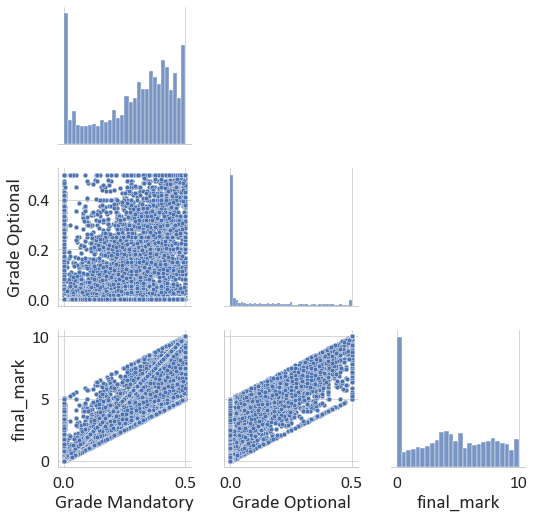

In [21]:
#Representation of different targets depending 
g = sns.PairGrid(targets_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

In [22]:
#a larger overlook at the different courses
targets_table.groupby('course').agg({
                                    'userid' : 'count', 
                                    'Grade Mandatory' : ['min', 'mean', 'max'],
                                    'Grade Optional' : ['min', 'mean', 'max'],                                    
                                    'final_mark' : ['min', 'mean', 'max'],
                                    }).describe(include = 'all')

userid Grade Mandatory                         Grade Optional  \
            count             min        mean         max            min   
count  226.000000      204.000000  204.000000  204.000000     176.000000   
mean    98.039823        0.068974    0.296908    0.439140       0.021091   
std     67.937836        0.112522    0.116339    0.113618       0.073206   
min     50.000000        0.000000    0.001987    0.003375       0.000000   
25%     63.000000        0.000000    0.235109    0.443374       0.000000   
50%     79.000000        0.000021    0.318609    0.485919       0.000000   
75%    108.750000        0.118546    0.383035    0.500000       0.000000   
max    667.000000        0.500000    0.500000    0.500000       0.500000   

                               final_mark                          
             mean         max         min        mean         max  
count  176.000000  176.000000  226.000000  226.000000  226.000000  
mean     0.107321    0.266057    0.855059    4.467472    7.810031  
std      0.135907    0.207995    1.733337    2.521210    2.674114  
min      0.000000    0.000000    0.000000    0.002941    0.128000  
25%      0.000366    0.010875    0.000000    2.588735    6.046762  
50%      0.046709    0.310077    0.000000    4.417945    9.031824  
75%      0.180259    0.475338    0.691668    6.388102   10.000000  
max      0.500000    0.500000   10.000000   10.000000   10.000000

#### Finally, we will take a look at the support table we have and repeat the same steps performed thus far

In [23]:
#separate logs accordingly
support_table = support_table[support_table['assign_id'].isin(student_logs['cmid'])].rename(columns = {
                                                                                            'courseid' : 'course'
                                                                                            })
#filter student logs_approppriately
student_logs = student_logs[student_logs['course'].isin(support_table['course'])].reset_index(drop = True)

#get info
support_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151599 entries, 219 to 220922
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   assign_id         151599 non-null  object        
 1   course            151599 non-null  object        
 2   startdate         151599 non-null  datetime64[ns]
 3   userid            151599 non-null  object        
 4   sup_time          151599 non-null  datetime64[ns]
 5   mandatory_status  151599 non-null  float64       
 6   delivered         151599 non-null  int64         
 7   assignment_mark   151599 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 10.4+ MB


In [24]:
support_table.describe(include = 'all', datetime_is_numeric = True)

,assign_id,course,startdate,userid,sup_time,mandatory_status,delivered,assignment_mark
count,151599,151599,151599,151599,151599,151599.000000,151599.000000,151599.000000
unique,2880,225,NaN,10853,NaN,NaN,NaN,NaN
top,98648.0,2271.0,NaN,68973.0,NaN,NaN,NaN,NaN
freq,657,12987,NaN,106,NaN,NaN,NaN,NaN
mean,NaN,NaN,2014-11-21 07:12:59.443136512,NaN,2015-02-08 12:12:58.046049280,0.573665,0.622524,0.427966
min,NaN,NaN,2014-08-25 00:00:00,NaN,2014-09-04 16:41:44,0.000000,0.000000,0.000000
25%,NaN,NaN,2014-09-08 00:00:00,NaN,2014-12-04 20:17:44,0.000000,0.000000,0.000000
50%,NaN,NaN,2014-12-08 00:00:00,NaN,2015-02-20 15:05:33,1.000000,1.000000,0.400599
75%,NaN,NaN,2015-01-26 00:00:00,NaN,2015-04-17 17:03:47.500000,1.000000,1.000000,0.851485
max,NaN,NaN,2015-05-18 00:00:00,NaN,2015-07-15 21:13:32,1.000000,1.000000,1.000000


In [25]:
support_table

,assign_id,course,startdate,userid,sup_time,mandatory_status,delivered,assignment_mark
219,5196.0,174.0,2014-09-08,52123.0,2014-11-18 14:56:51,1.0,1,0.702970
220,5196.0,174.0,2014-09-08,57173.0,2014-11-18 14:46:09,1.0,1,0.653465
221,5196.0,174.0,2014-09-08,60625.0,2014-11-18 15:04:49,1.0,1,0.851485
222,5196.0,174.0,2014-09-08,60643.0,2014-11-18 14:44:08,1.0,1,0.752475
223,5196.0,174.0,2014-09-08,60694.0,2014-11-18 14:48:36,1.0,1,0.752475
...,...,...,...,...,...,...,...,...
220918,272791.0,5646.0,2015-02-02,55804.0,2015-05-27 15:17:53,1.0,1,0.900000
220919,272791.0,5646.0,2015-02-02,60489.0,2015-05-22 16:09:00,1.0,1,0.300000
220920,272791.0,5646.0,2015-02-02,66527.0,2015-05-27 19:41:48,1.0,1,0.900000
220921,272791.0,5646.0,2015-02-02,77034.0,2015-05-27 14:32:56,1.0,1,1.000000


In [26]:
#a larger overlook at the different courses
support_table.groupby('course').agg({
                                    'userid' : 'count',
                                    'assign_id' : 'count', 
                                    'mandatory_status' : 'mean',
                                    'delivered' : 'mean',                                    
                                    'assignment_mark' : 'mean',
                                    }).describe(include = 'all')

,userid,assign_id,mandatory_status,delivered,assignment_mark
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,673.773333,673.773333,0.659141,0.704088,0.472424
std,1045.644340,1045.644340,0.359659,0.316127,0.272273
min,52.000000,52.000000,0.000000,0.000000,0.000000
25%,225.000000,225.000000,0.355120,0.471136,0.240235
50%,405.000000,405.000000,0.810219,0.816667,0.507158
75%,815.000000,815.000000,1.000000,0.993432,0.691589
max,12987.000000,12987.000000,1.000000,1.000000,1.000000


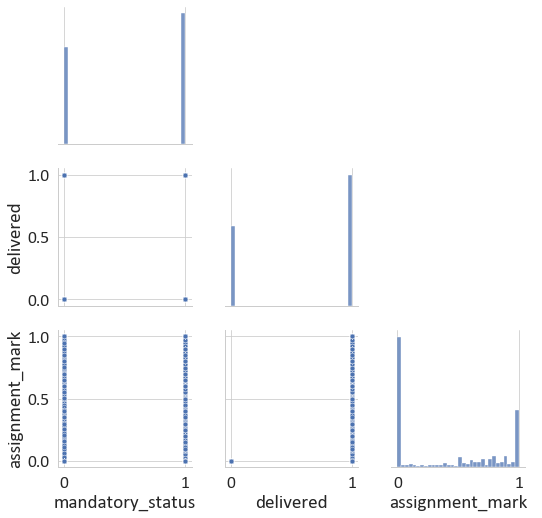

In [27]:
#Representation of different targets depending 
g = sns.PairGrid(support_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

**Going forward**.

After this preliminary look, we will go forward with extracting features from the Moodle logs. 

In this notebook, we will consider a temporal representation that considers each student-course pair as a row and each column to represent a day in the course.

An important distinction is that we do not have to perform multiple pre-processing steps. Instead we get, for each row, a sequence of the daily number of clicks.

In [28]:
#additionally, we will look at our estimated course duration
for i in tqdm(duration_threshold):
    #create, for each desired threshold, the appropriate cutoff date 
    class_list[f'Date_threshold_{int(i*100)}'] = pd.to_datetime((class_list['Start Date'] + pd.to_timedelta(class_list['Course duration days'] * i, unit = 'Days')).dt.date)
    
    #setting up duration threshold to be on friday -> reason being that it will be easier to 
    class_list[f'Date_threshold_{int(i*100)}'] = class_list[f'Date_threshold_{int(i*100)}'].where( class_list[f'Date_threshold_{int(i*100)}'] == (( class_list[f'Date_threshold_{int(i*100)}'] + Week(weekday=4)) - Week()), class_list[f'Date_threshold_{int(i*100)}'] + Week(weekday=4))

#then, we will create a dictionary of dictionaries, each main dictionary storing and a version of the logs
logs_dict = {}
assignment_dict = {}

for i in tqdm(duration_threshold):
    #create, for each desired threshold, a different dictionary of dataframes wherein we will perform the different operations
    print(f'Date_threshold_{int(i*100)}\n' +
          f'Logs')
    logs_dict[f'Date_threshold_{int(i*100)}'] = {course: student_logs.loc[student_logs['course'] == course].reset_index(drop = True) for course in tqdm(student_logs['course'].unique())}
    
    #Assignments
    print(f'Assignments')
    assignment_dict[f'Date_threshold_{int(i*100)}'] = {course: support_table.loc[support_table['course'] == course].reset_index(drop = True) for course in tqdm(support_table['course'].unique())}

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10
Logs


  0%|          | 0/225 [00:00<?, ?it/s]

Assignments


  0%|          | 0/225 [00:00<?, ?it/s]

Date_threshold_25
Logs


  0%|          | 0/225 [00:00<?, ?it/s]

Assignments


  0%|          | 0/225 [00:00<?, ?it/s]

Date_threshold_33
Logs


  0%|          | 0/225 [00:00<?, ?it/s]

Assignments


  0%|          | 0/225 [00:00<?, ?it/s]

Date_threshold_50
Logs


  0%|          | 0/225 [00:00<?, ?it/s]

Assignments


  0%|          | 0/225 [00:00<?, ?it/s]

Date_threshold_100
Logs


  0%|          | 0/225 [00:00<?, ?it/s]

Assignments


  0%|          | 0/225 [00:00<?, ?it/s]

Now, we have a nested dictionary with different dataframes inside it. We will use this data structure to perform the most of the operations we are interested in.

**First, we will add, to each dataframe, a column with the corresponding threshold date**

After this cleaning procedure, we will, for each course get the daily clicks and put them on a pivot_table. We will finish the procedure by exporting updated versions of the class list as these will also need to be used going forward.

In [29]:
#for each intended course duration threshold
for i in tqdm(logs_dict):
    #start with creating a dictionary of course and intended cuttoff date
    cut = class_list.set_index('course').to_dict()[i] 
    
    #for each dataframe
    for j in tqdm(logs_dict[i]):
        #where the course is the same as in the class_list, get the corresponding value of the appropriate column,
        logs_dict[i][j]['Date Threshold'] = logs_dict[i][j]['course'].map(cut)
        logs_dict[i][j] = logs_dict[i][j][logs_dict[i][j]['time'] <= logs_dict[i][j]['Date Threshold']].reset_index(drop = True).drop('Date Threshold', axis = 1)

        #Aggregate by day
        logs_dict[i][j] = logs_dict[i][j].groupby(['course', pd.Grouper(key='time', freq='D'), 'userid']).agg({
                                                                                                                'action': 'count', 
                                                                                                                }).reset_index().sort_values('time')
        
        #then, we create a pivot_table
        logs_dict[i][j] = pd.pivot_table(logs_dict[i][j], index=['course', 'userid'], columns = 'time', values = 'action',
                    aggfunc='sum')
        
        #and rename columns to fit with the number of days
        logs_dict[i][j] = logs_dict[i][j].rename(columns={x:y for x,y in zip(logs_dict[i][j].columns,range(1,len(logs_dict[i][j].columns) + 1))}).reset_index()
        logs_dict[i][j].columns.name = None
        
        #joining final grade for target
        logs_dict[i][j] = logs_dict[i][j].merge(targets_table.filter(['course', 'userid', 'final_mark']), on = ['course', 'userid'], how = 'right')
        
    #after the end of the loops:
    logs_dict[i] = pd.concat(logs_dict[i], ignore_index=True)
    logs_dict[i] = logs_dict[i].sort_values(by = ['course', 'userid', 'final_mark']).reset_index(drop = True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

In [30]:
#create backup of logs dict, we will need it for later
backup = deepcopy(logs_dict)

In [31]:
logs_dict = deepcopy(backup)

In order to account for situations where registered students only access Moodle later in the course, we will make ann additional, but necessary adaptation. 

We will start by looking at the complete set of valid students/courses in our 100% dataset. From these, we get the indexes of the rows that are valid (i.e. have a valid click count at 100% duration), get the indexes and retain only these.

In [32]:
#we gather the index number of valid rows in the 100% df
rows_to_keep = logs_dict['Date_threshold_100'][~logs_dict['Date_threshold_100'][1].isna()].index

# #then slice accordingly
for i in tqdm(logs_dict):
    logs_dict[i] = logs_dict[i].iloc[rows_to_keep, :].reset_index(drop = True)

  0%|          | 0/5 [00:00<?, ?it/s]

#### Almost Done.

We will finish this step momentarily. Before we do, we need to save all dfs in an easily accessible Excel File.

In [33]:
writer = pd.ExcelWriter('../Data/Modeling Stage/R_gonz_Temporal_Datasets.xlsx', engine='xlsxwriter')

#now loop thru and put each on a specific sheet
for sheet, frame in  logs_dict.items(): 
    frame.to_excel(writer, sheet_name = sheet)

#critical last step
writer.save()

#also saving additional info on class list
class_list.to_csv('../Data/Modeling Stage/R_Gonz_updated_classlist.csv')